In [1]:
# IMPORT MODULES

import numpy as np
from numpy import ma
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline
from matplotlib import ticker, cm
from matplotlib.pyplot import figure
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets, decomposition, preprocessing

from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM

from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

Using TensorFlow backend.


/opt/anaconda3/envs/Autoencoder/lib/python3.6/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


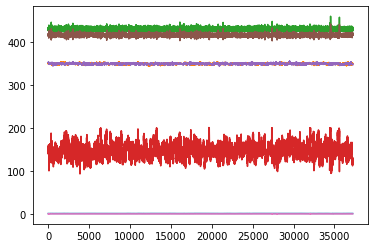

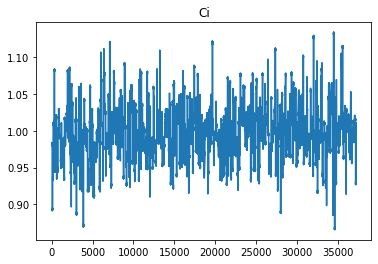

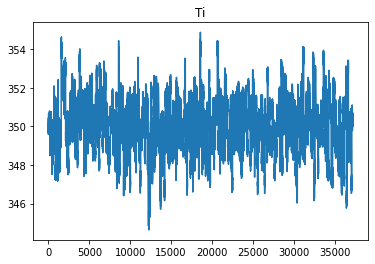

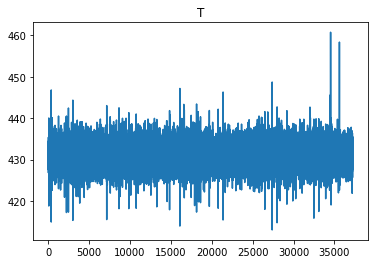

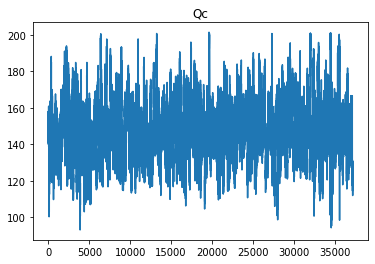

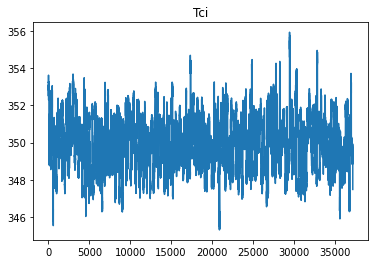

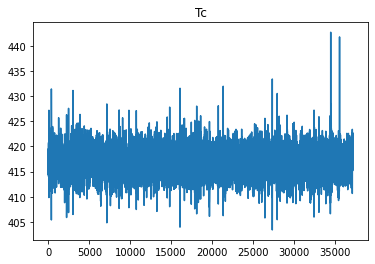

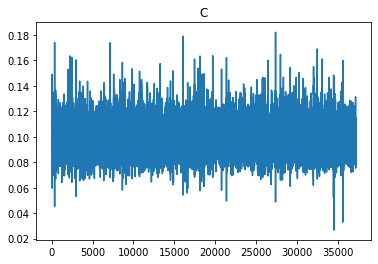

In [2]:
dfRaw = pd.read_excel('Model data.xlsx',engine='openpyxl')
df=dfRaw
# print(dfRaw.shape)
# print(dfRaw.columns)

d=dfRaw.iloc[:,2:9]
plt.plot(d)
plt.show()
name=['Ci', 'Ti', 'T', 'Qc', 'Tci', 'Tc', 'C']

for i in range(7):
    plt.plot(d.iloc[:,i])
    plt.title(name[i], fontdict=None, loc='center', pad=None)
    plt.show()

In [3]:
data = dfRaw.copy()
normal_data = data.loc[data["Class"] == 0]
fault_data = data.loc[data["Class"] == 1]

print("data ", data.shape)
print("normal_data ", normal_data.shape)
print("fault data ", fault_data.shape)
print("Percent fault ", round((len(fault_data)/len(data)), 4),"%")


data  (37229, 9)
normal_data  (37229, 9)
fault data  (0, 9)
Percent fault  0.0 %


/opt/anaconda3/envs/Autoencoder/lib/python3.6/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


------------------------------------------------------------------------
Training for fold 0 ...


TypeError: 'Text' object is not callable

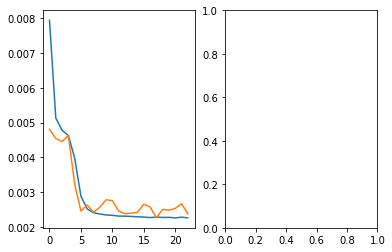

In [4]:
import tensorflow as tf
import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


from sklearn.model_selection import train_test_split
import sklearn
from sklearn import datasets
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import decomposition
import scipy


from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets, decomposition, preprocessing
from sklearn.model_selection import KFold


df = pd.read_excel('Model data.xlsx',engine='openpyxl')
# all features
x = df[df.columns[2:9]].to_numpy()

# column with class
y = df[df.columns[1]].to_numpy()


# This portion of code remove anomalies if the dataset contained anomalies

df = pd.concat([pd.DataFrame(x), pd.DataFrame({'anomaly': y})], axis=1)
normal_events = df[df['anomaly'] == 0]


normal_events = normal_events.loc[:, normal_events.columns != 'anomaly']




# # scaling
scaler = preprocessing.MinMaxScaler()

scaler.fit(df.drop('anomaly', 1))

scaled_data = scaler.transform(normal_events)

# # 80% percent of dataset is designated to training
train_data, test_data = train_test_split(scaled_data, test_size=0.1)
n_features = x.shape[1]

inputs = np.concatenate((train_data, test_data), axis=0)


# Define the K-fold Cross Validator
num_folds=5
kfold = KFold(n_splits=num_folds, shuffle=True)

acc=[]
val_acc=[]
prediction_loss_error=[]

i=0

for train, test in kfold.split(inputs):
    
    # # model
    encoder = keras.Sequential(name='encoder')
    encoder.add(layer=keras.layers.Dense(units=20, activation=keras.activations.relu, input_shape=[n_features]))
    encoder.add(keras.layers.Dropout(0.1))
    encoder.add(layer=keras.layers.Dense(units=10, activation=keras.activations.relu))
    encoder.add(layer=keras.layers.Dense(units=5, activation=keras.activations.relu))

    decoder = keras.Sequential(name='decoder')
    decoder.add(layer=keras.layers.Dense(units=10, activation=keras.activations.relu, input_shape=[5]))
    decoder.add(layer=keras.layers.Dense(units=20, activation=keras.activations.relu))
    decoder.add(keras.layers.Dropout(0.1))
    decoder.add(layer=keras.layers.Dense(units=n_features, activation=keras.activations.sigmoid))

    autoencoder = keras.Sequential([encoder, decoder])

    autoencoder.compile(
        loss=keras.losses.MSE,
        optimizer=keras.optimizers.Adam(),
        metrics=[keras.metrics.mean_squared_error,'accuracy'])
    

    # train model
    es = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=5, restore_best_weights=True)
#     history = autoencoder.fit(x=train_data, y=train_data, epochs=100, verbose=1, validation_data=[test_data, test_data], callbacks=[es])
    
    
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {i} ...')

    # Fit data to model
    history = autoencoder.fit(x=inputs[train], y=inputs[train], epochs=50, verbose=0, validation_data=[test_data, test_data], callbacks=[es])
    
    
    # Mean Squared error
    train_predicted_x = autoencoder.predict(x=inputs[train])
    train_events_mse=sklearn.metrics.mean_squared_error(inputs[train], train_predicted_x)

    prediction_loss_error.append(train_events_mse)
    acc.append(history.history['accuracy'])
    val_acc.append(history.history['val_accuracy'])
    
#     plt.plot(history.history['loss'])
#     plt.plot(history.history['val_loss'])
#     plt.title('Model Loss')
#     plt.ylabel('Loss')
#     plt.xlabel('Epoch')
#     plt.legend(['Train', 'Test'], loc='upper left')
#     plt.show()
    
    
#     plt.plot(history.history['accuracy'])
#     plt.plot(history.history['val_accuracy'])
#     plt.title('model accuracy')
#     plt.ylabel('accuracy')
#     plt.xlabel('epoch')
#     plt.legend(['train', 'test'], loc='upper left')
#     plt.show()
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
#     ax1.title('Model Loss')
    ax1.ylabel('Loss')
    ax1.xlabel('Epoch')
    ax1.legend(['Train', 'Test'], loc='upper left')
    ax2.plot(history.history['accuracy'])
    ax2.plot(history.history['val_accuracy'])
#     ax2.title('model accuracy')
    ax2.ylabel('accuracy')
    ax2.xlabel('epoch')
    ax2.legend(['train', 'test'], loc='upper left')
    plt.show()

    i=i+1


# Increase fold number
i = i + 1

print(f'> Loss: {np.mean(prediction_loss_error)}')
print(f'> acc: {np.mean(acc)}')
print(f'> val_acc: {np.mean(val_acc)}')

/opt/anaconda3/envs/Autoencoder/lib/python3.6/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


Train on 26060 samples, validate on 11169 samples
Epoch 1/20
26060/26060 [==============================] - 2s 66us/sample - loss: 0.0358 - accuracy: 0.5502 - val_loss: 0.0309 - val_accuracy: 0.6634
Epoch 2/20
26060/26060 [==============================] - 1s 43us/sample - loss: 0.0307 - accuracy: 0.7179 - val_loss: 0.0303 - val_accuracy: 0.7701
Epoch 3/20
26060/26060 [==============================] - 1s 43us/sample - loss: 0.0304 - accuracy: 0.7805 - val_loss: 0.0302 - val_accuracy: 0.7998
Epoch 4/20
26060/26060 [==============================] - 1s 43us/sample - loss: 0.0304 - accuracy: 0.8027 - val_loss: 0.0302 - val_accuracy: 0.8159
Epoch 5/20
26060/26060 [==============================] - 1s 43us/sample - loss: 0.0303 - accuracy: 0.8180 - val_loss: 0.0301 - val_accuracy: 0.8275
Epoch 6/20
26060/26060 [==============================] - 1s 43us/sample - loss: 0.0303 - accuracy: 0.8226 - val_loss: 0.0301 - val_accuracy: 0.8271
Epoch 7/20
26060/26060 [==============================] 

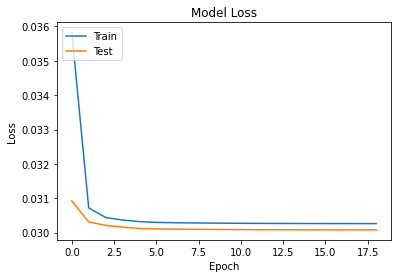

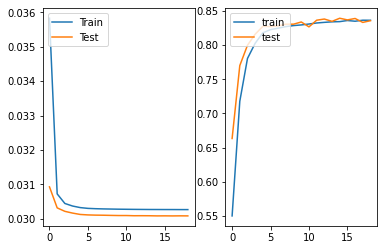

In [7]:

import tensorflow as tf
import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets, decomposition, preprocessing

from keras.callbacks import ModelCheckpoint, TensorBoard



df = pd.read_excel('Model data.xlsx',engine='openpyxl')
# all features
x = df[df.columns[2:9]].to_numpy()

# column with class
y = df[df.columns[1]].to_numpy()


# This portion of code remove anomalies if the dataset contained anomalies

df = pd.concat([pd.DataFrame(x), pd.DataFrame({'anomaly': y})], axis=1)
normal_events = df[df['anomaly'] == 0]


normal_events = normal_events.loc[:, normal_events.columns != 'anomaly']




# # scaling
scaler = preprocessing.MinMaxScaler()

scaler.fit(df.drop('anomaly', 1))

scaled_data = scaler.transform(normal_events)

# # 80% percent of dataset is designated to training
train_data, test_data = train_test_split(scaled_data, test_size=0.3)

n_features = x.shape[1]

train_x=train_data
test_x=test_data
nb_epoch = 100
batch_size = 128
input_dim = train_x.shape[1] #num of columns, 30
encoding_dim = 14
hidden_dim = int(encoding_dim / 2) #i.e. 7
learning_rate = 1e-7

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

cp = ModelCheckpoint(filepath="autoencoder_fraud.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)





autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

# history = autoencoder.fit(train_x, train_x,
#                     epochs=nb_epoch,
#                     batch_size=batch_size,
#                     shuffle=True,
#                     validation_data=(test_x, test_x),
#                     verbose=0,
#                     callbacks=[cp, tb]).history


history = autoencoder.fit(x=train_x, y=train_x, epochs=20, verbose=1, validation_data=[test_x, test_x], callbacks=[es])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])

ax1.legend(['Train', 'Test'], loc='upper left')
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])

ax2.legend(['train', 'test'], loc='upper left')
plt.show()


# test_x_predictions = autoencoder.predict(test_x)
# mse = np.mean(np.power(test_x - test_x_predictions, 2), axis=1)
# error_df = pd.DataFrame({'Reconstruction_error': mse})
# error_df.describe()


/opt/anaconda3/envs/Autoencoder/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


MSE
0.06160900946706532
0.030266114


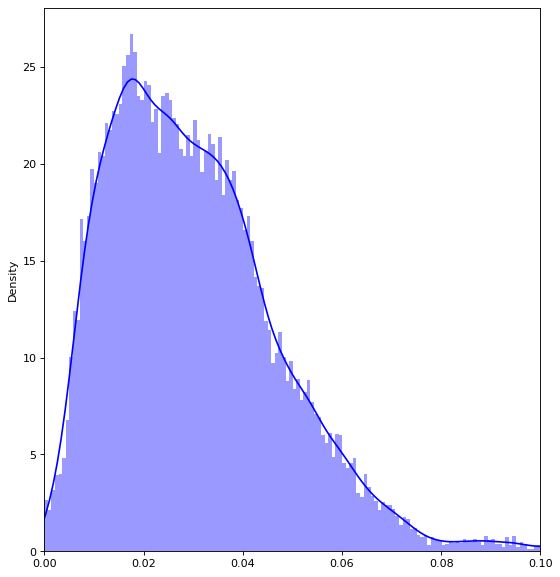

In [10]:

# Mean Squared error
train_predicted_x = autoencoder.predict(x=train_data)
train_events_mse = keras.losses.mean_squared_error(train_data, train_predicted_x)
cut_off = np.percentile(train_events_mse, 95)

# loss distribution

plt.figure(figsize=(8,9), dpi=80)
sns.distplot(train_events_mse, bins=200, kde=True, color='blue')
plt.xlim([0., .1]);


print('MSE')
print(cut_off)
print(np.average(train_events_mse.numpy()))




                mse  cutoff
0     239528.031250   0.001
1     240110.093750   0.001
2     240242.453125   0.001
3     240679.843750   0.001
4     240114.828125   0.001
...             ...     ...
1196  241797.750000   0.001
1197  242488.218750   0.001
1198  242599.625000   0.001
1199  242671.234375   0.001
1200  236719.406250   0.001

[1201 rows x 2 columns]


/opt/anaconda3/envs/Autoencoder/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


''

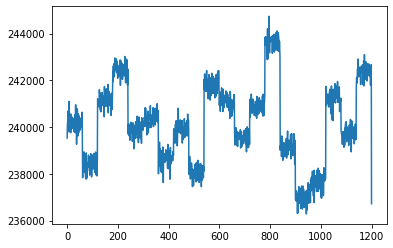

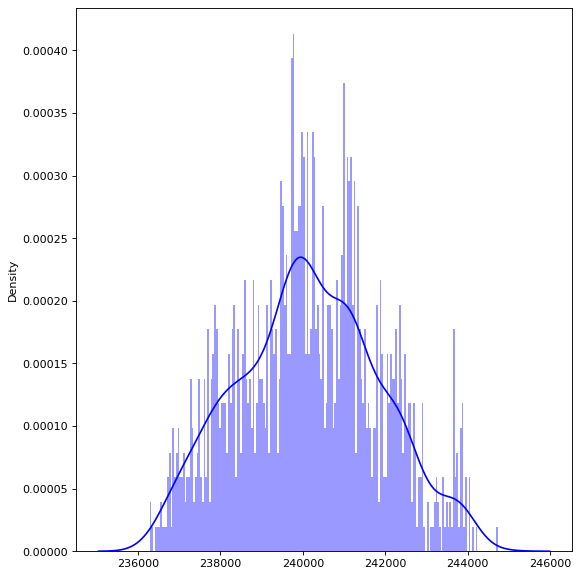

In [15]:
# Import dataset whihc has a fault to be detected

df = pd.read_excel('Fault 30.xlsx',engine='openpyxl')
# df=df.iloc[:,2:8]
# plt.plot(df)




plot_samples=1201
# all features
x = df[df.columns[2:9]].to_numpy()

# column with class
y = df[df.columns[1]].to_numpy()



# Creating a data frame and calling the class "Anomaly"
abnormal_events = pd.concat([pd.DataFrame(x), pd.DataFrame({'anomaly': y})], axis=1)
abnormal_events = abnormal_events.loc[:, abnormal_events.columns != 'anomaly']

# abnormal event
abnormal_x = scaler.transform(abnormal_events).reshape(plot_samples, n_features)
predicted_x = autoencoder.predict(abnormal_x)
abnormal_events_mse = keras.losses.mean_squared_error(abnormal_x, predicted_x)
abnormal_events_df = pd.DataFrame({
    
	'n': np.arange(0, plot_samples),    
	'mse': abnormal_events_mse})


Final=pd.DataFrame(abnormal_events_df.mse)

Final['cutoff']=0.001

print(Final)
plt.plot(abnormal_events_df.mse)


# abnormal_events_df.to_excel('test4.xlsx')


plt.figure(figsize=(8,9), dpi=80)
sns.distplot(abnormal_events_mse, bins=200, kde=True, color='blue')
;

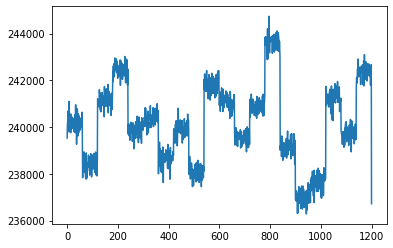

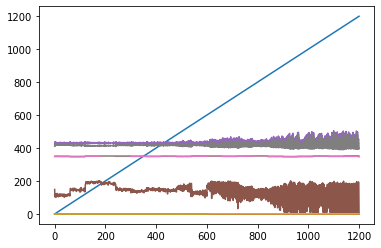

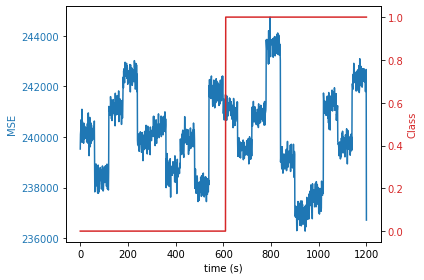

In [16]:
import numpy as np
import matplotlib.pyplot as plt



plt.plot(abnormal_events_df.mse)
plt.show()
df = pd.read_excel('Fault 30.xlsx',engine='openpyxl')
plt.plot(df)
plt.show()


df=df.Class
data1 = abnormal_events_mse
data2 = df

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('MSE', color=color)
ax1.plot(data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Class', color=color)  # we already handled the x-label with ax1
ax2.plot(data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()